In [1]:
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
# Отключение некоторых лишних предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('new_data.csv')
df['Дата']=pd.to_datetime(df['Дата'])
# превращение в индекс
df.set_index('Дата', inplace=True)
df=df[['Доллар США', 'Евро', 'Фунт стерлингов', 'Китайский юань',
       'Японская йена', 'value_RUB', 'value_USD', 'value_EUR', 'value_GBP', 'value_CNY',
       'value_JPY']]
df

,Доллар США,Евро,Фунт стерлингов,Китайский юань,Японская йена,value_RUB,value_USD,value_EUR,value_GBP,value_CNY,value_JPY
Дата,,,,,,,,,,,
2023-12-05,75.8846,82.8877,95.7512,10.9119,56.5881,7.5,5.06143,-0.64957,4.68770,1.320000,-0.06005
2023-11-05,76.6929,84.1498,96.7251,11.0390,56.7465,7.5,5.06171,-0.64957,4.68100,1.102000,-0.06005
2023-05-05,78.6139,86.9986,98.5268,11.3488,57.1654,7.5,5.05986,-0.64957,4.63360,1.234000,-0.06005
2023-04-05,79.3071,87.5750,98.9118,11.4456,57.6695,7.5,5.05871,-0.64957,4.63370,1.658000,-0.06005
2023-03-05,79.9609,87.6556,100.4789,11.4884,58.1449,7.5,4.81086,-0.64957,4.62320,1.388818,-0.06005
...,...,...,...,...,...,...,...,...,...,...,...
2015-05-22,49.9204,55.5714,77.8858,80.5584,41.2924,12.5,0.12400,-0.17643,0.57063,2.494300,0.07000
2015-05-21,49.7919,55.2441,77.1774,80.2603,41.1622,12.5,0.12400,-0.17786,0.56688,2.494300,0.07143
2015-05-20,49.1777,55.1085,76.5943,79.2307,40.9797,12.5,0.12400,-0.17786,0.56688,2.494300,0.06714


In [3]:
df.dtypes

Доллар США         float64
Евро               float64
Фунт стерлингов    float64
Китайский юань     float64
Японская йена      float64
value_RUB          float64
value_USD          float64
value_EUR          float64
value_GBP          float64
value_CNY          float64
value_JPY          float64
dtype: object

In [4]:
# разделим на тестовую и обучающую выборки
train, test = df[:'2019-12-31'], df['2020-01-01':]
train, test

(            Доллар США     Евро  Фунт стерлингов  Китайский юань  \
 Дата                                                               
 2019-12-31     61.9057  69.3406          81.1460         88.5937   
 2019-12-27     61.7676  68.5003          80.2114         88.2558   
 2019-12-26     61.7164  68.4065          80.1079         88.3847   
 2019-12-25     62.1673  68.9062          80.4072         88.7116   
 2019-12-24     62.2499  68.9978          81.0680         88.7636   
 ...                ...      ...              ...             ...   
 2015-05-22     49.9204  55.5714          77.8858         80.5584   
 2015-05-21     49.7919  55.2441          77.1774         80.2603   
 2015-05-20     49.1777  55.1085          76.5943         79.2307   
 2015-05-19     49.2175  56.1030          77.0992         79.3280   
 2015-05-15     50.0774  57.1383          78.9420         80.7505   
 
             Японская йена  value_RUB  value_USD  value_EUR  value_GBP  \
 Дата                      

In [5]:
df.columns

Index(['Доллар США', 'Евро', 'Фунт стерлингов', 'Китайский юань',
       'Японская йена', 'value_RUB', 'value_USD', 'value_EUR', 'value_GBP',
       'value_CNY', 'value_JPY'],
      dtype='object')

Сначала создадим функцию get_sharp_momentum. Её параметры: временной лаг, за который мы смотрим изменения в курсе валюты и в курсе денежной ставки – m; порог повышенной доходности – b – если этот порог достигается, то мы вкладываемся в бумагу овернайт
За время до временного лага мы ищем накопленную доходность за каждый день, чтобы сравнить с порогом повышенной доходности – так мы типа определяем, стоило ли вкладываться в бумагу тогда
Потом мы смотрим результаты по всем дням и составляем доходности итоговые для тех случаев, когда стоило вложиться в бумагу: умножаем изменение курса на изменение ставки овернайт. Далее наши подсчитанные retentions мы добавляем в отдельный список


In [20]:
def get_sharp_momentum(b, m):
    cum_ret_lst = [[],[],[],[],[]]
    sigma = []
    log_ret = [] 
    for z in range(5):
        element = ['Доллар США', 'Евро', 'Фунт стерлингов', 'Китайский юань',
       'Японская йена'][z]
        column = ['value_USD', 'value_EUR', 'value_GBP',
       'value_CNY', 'value_JPY'][z]
        ret = []
        cum_ret_lst[z].append(0)
        for i in range(m, pd.DataFrame(train[element]).shape[0]):
            ok = 1
            ok2 = 1
            cum_ret = 0
            for j in range(m):
                cum_ret += np.log(train[element][i-j-1]) - np.log(train[element][i-j-2])
                if cum_ret < b:
                    ok = 0
                if cum_ret > -b:
                    ok2 = 0
            
            # + r*np.log(train[element][i-1]) foreign interest
            # print(ok, ok2, ret_loc)
            if ok == 1 and train[column][i-1] >= 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1]) + np.log(1+train[column][i-1])-np.log(1+train['value_RUB'][i-1])
                ret.append(ret_loc)
            elif ok == 1 and train[column][i-1] < 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1])-np.log(1+train['value_RUB'][i-1])
                ret.append(ret_loc)
            elif ok2 == 1 and train[column][i-1] >= 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1]) + np.log(1+train[column][i-1])-np.log(1+train['value_RUB'][i-1])
                ret.append(-ret_loc)
            elif ok2 == 1 and train[column][i-1] < 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1]) -np.log(1+train['value_RUB'][i-1])
                ret.append(-ret_loc)
            else:
                ret.append(0)

            cum_ret_lst[z].append(cum_ret_lst[z][-1] + ret[-1]) # При добавлении доходности весь прошлый ретерн должен домножаться на рублевую ставку

        # plt.plot(cum_ret_lst)
        # annual volatility of the strategy
        log_ret.append(ret)
    return(cum_ret_lst, log_ret)

In [21]:
get_sharp_momentum(0.02, 3)[0][3]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.2660237497466174,
 1.2660237497466174,
 1.2660237497466174,
 1.2660237497466174,
 1.2660237497466174,
 1.2660237497466174,
 1.2660237497466174,
 1.2660237497466174,
 1.2660237497466174,
 1.2660237497466174,
 1

Далее в цикле с sharp_list мы хотим найти так называемые «веса доверия» для бумаг: если с расчетом за временной лаг бумага больше, в среднем, росла в доходности в дальнейшем, то вес будет положительным, наоборот: если она потом падала в доходности, то вес отрицателен. Если вес получился нулевым, то мы ничего особо не знаем о бумаге: она слишком неопределенная. 
Получим следующие веса:

In [13]:

sharp_list = []
w = [[], [], [], [], []]
for w1 in np.arange(-3.0,3.1,1):
    for w2 in np.arange(-3.0,3.1,1):
        for w3 in np.arange(-3.0,3.1,1):
            for w4 in np.arange(-3.0,3.1,1):
                for w5 in np.arange(-3.0,3.1,1):
                    ## кучу раз прогнав цикл, мы пришли к выводу, что более или менее нас устраивает порог в 0,16% доходности за день
                    b = 0.0016
                    m = 1
                    usd = get_sharp_momentum(0.05, 5)[0][0]
                    eur = get_sharp_momentum(0.05, 5)[0][1]
                    pound = get_sharp_momentum(0.05, 5)[0][2]
                    yuan = get_sharp_momentum(0.05, 5)[0][3]
                    yen = get_sharp_momentum(0.05, 5)[0][4]
                    weights = np.array([w1, w2, w3, w4, w5])
                    log_returns = np.array(get_sharp_momentum(b,m)[1])
                    mean_usd = np.mean(log_returns[0])
                    mean_eur = np.mean(log_returns[1])
                    mean_pound = np.mean(log_returns[2])
                    mean_yuan = np.mean(log_returns[3])
                    mean_yen = np.mean(log_returns[4])
                    mean = w1*mean_usd + w2*mean_eur +  w3*mean_pound + w4* mean_yuan + w5* mean_yen
                    sd = np.dot(weights.T,np.dot(np.cov(log_returns)*252,weights))
                    sharp = mean/sd
                    sharp_list.append(sharp)
                    w[0].append(w1)
                    w[1].append(w2)
                    w[2].append(w3)
                    w[3].append(w4)
                    w[4].append(w5)
sharp_list.index(np.max(sharp_list[-len(w[0]):]))
sharp_weight = sharp_list[-len(w[0]):]
print(w[0][sharp_weight.index(np.max(sharp_weight))])
print(w[1][sharp_weight.index(np.max(sharp_weight))])
print(w[2][sharp_weight.index(np.max(sharp_weight))])
print(w[3][sharp_weight.index(np.max(sharp_weight))])
print(w[4][sharp_weight.index(np.max(sharp_weight))])

2.0
1.0
1.0
-1.0
0.0


Следующая функция считает повышенные доходности от данных в тестовой выборке

In [8]:
def get_profit(b, m):
    cum_ret_lst = [[],[],[],[], []]
    trade = [[],[],[],[], []]
    sigma = []
    log_ret = [] 
    for z in range(5):
        element = ['Доллар США', 'Евро', 'Фунт стерлингов', 'Китайский юань',
       'Японская йена'][z]
        column = ['value_USD', 'value_EUR', 'value_GBP',
       'value_CNY', 'value_JPY'][z]
        ret = []
        cum_ret_lst[z].append(0)
        for i in range(m, pd.DataFrame(test[element]).shape[0]):
            ok = 1
            ok2 = 1
            cum_ret = 0
            for j in range(m):
                cum_ret += np.log(test[element][i-j-1]) - np.log(test[element][i-j-2])
                if cum_ret < b:
                    ok = 0
                if cum_ret > -b:
                    ok2 = 0
            
            # + r*np.log(train[element][i-1]) foreign interest
            # print(ok, ok2, ret_loc)
            if ok == 1 and test[column][i-1] >= 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1]) + np.log(1+test[column][i-1])-np.log(1+test['value_RUB'][i-1])
                ret.append(0.9975*ret_loc)
            elif ok == 1 and test[column][i-1] < 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1])-np.log(1+test['value_RUB'][i-1])
                ret.append(0.9975*ret_loc)
            elif ok2 == 1 and test[column][i-1] >= 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1]) + np.log(1+test[column][i-1])-np.log(1+test['value_RUB'][i-1])
                ret.append(-ret_loc*0.9975)
            elif ok2 == 1 and test[column][i-1] < 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1]) -np.log(1+test['value_RUB'][i-1])
                ret.append(-ret_loc*0.99975)
            else:
                ret.append(np.log(1+test['value_RUB'][i]+np.random.uniform(-0.0005,0.0005)))

            cum_ret_lst[z].append(cum_ret_lst[z][-1] + ret[-1]) # При добавлении доходности весь прошлый ретерн должен домножаться на рублевую ставку
            trade[z].append(1*ok+1*ok2)
        # plt.plot(cum_ret_lst)
        # annual volatility of the strategy
        log_ret.append(ret)
    return(cum_ret_lst, log_ret, trade)

In [9]:
usd = np.array(get_profit(0.016, 1)[0][0])
eur = np.array(get_profit(0.016, 1)[0][1])
pound = np.array(get_profit(0.016, 1)[0][2])
yuan = np.array(get_profit(0.016, 1)[0][3])
yen = np.array(get_profit(0.016, 1)[0][4])
usd #for example

array([ 0.00000000e+00, -3.26706235e-01,  1.81332554e+00,  1.48454921e+00,
        3.62467103e+00,  5.76477151e+00,  5.38623156e+00,  7.52633504e+00,
        9.66642967e+00,  1.18065308e+01,  1.39466081e+01,  1.60866589e+01,
        1.82267136e+01,  2.03667626e+01,  2.25068480e+01,  2.46469188e+01,
        2.67869933e+01,  2.89270853e+01,  3.10671915e+01,  3.32073153e+01,
        3.53473689e+01,  3.57377367e+01,  3.78778269e+01,  4.00178677e+01,
        4.21579163e+01,  4.42979640e+01,  4.64380288e+01,  4.85780596e+01,
        5.07181303e+01,  5.28581494e+01,  5.49982517e+01,  5.71382609e+01,
        5.92783830e+01,  6.14184344e+01,  6.35585363e+01,  6.56986259e+01,
        6.78386596e+01,  6.99786877e+01,  7.21187948e+01,  7.42588375e+01,
        7.63988940e+01,  7.85389701e+01,  8.06790497e+01,  8.28191448e+01,
        8.49591981e+01,  8.70992894e+01,  8.92394118e+01,  9.13794220e+01,
        9.35195410e+01,  9.39527812e+01,  9.60928392e+01,  9.82328941e+01,
        1.00372921e+02,  

Теперт посчитаем эффект от нашей стратегии в каждый день теста

In [28]:
weighted_cum_ret = w1*usd+w2*eur+w3*pound + w4*yuan +w5*yen

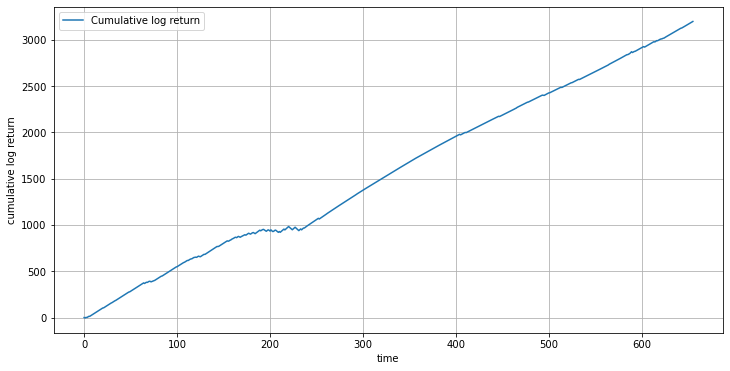

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(weighted_cum_ret, label = 'Cumulative log return')
plt.grid()
plt.legend()
plt.xticks()
plt.xlabel('time')
plt.ylabel('cumulative log return');

Теперь посмотрим, когда же, по нашей стратегии, мы в итоге держали бумагу в риск-фри ставке (в рублевой), а когда - совершали с валютами сделки

In [60]:
usd_hold = get_profit(0.016, 1)[2][0].count(0)/len(get_profit(0.016, 1)[2][0])
usd_trade = 1-get_profit(0.016, 1)[2][0].count(0)/len(get_profit(0.016, 1)[2][0])
eur_hold = get_profit(0.016, 1)[2][1].count(0)/len(get_profit(0.016, 1)[2][1])
eur_trade = 1-get_profit(0.016, 1)[2][1].count(0)/len(get_profit(0.016, 1)[2][1])
pound_hold = get_profit(0.016, 1)[2][2].count(0)/len(get_profit(0.016, 1)[2][2])
pound_trade = 1-get_profit(0.016, 1)[2][2].count(0)/len(get_profit(0.016, 1)[2][2])
yuan_hold = get_profit(0.016, 1)[2][3].count(0)/len(get_profit(0.016, 1)[2][3])
yuan_trade = 1-get_profit(0.016, 1)[2][3].count(0)/len(get_profit(0.016, 1)[2][3])
yen_hold = get_profit(0.016, 1)[2][3].count(0)/len(get_profit(0.016, 1)[2][3])
yen_trade = 1-get_profit(0.016, 1)[2][3].count(0)/len(get_profit(0.016, 1)[2][3])

Посмотрим, насколько каждое действие часто, на графике

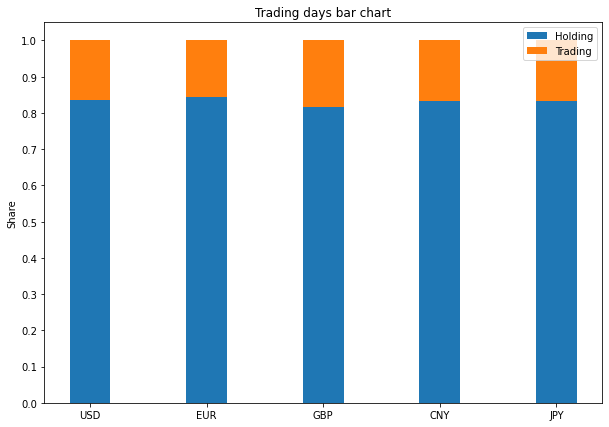

In [31]:
ind = np.arange(5)
hold = [usd_hold, eur_hold, pound_hold, yuan_hold, yen_hold]
trade = [usd_trade, eur_trade, pound_trade, yuan_trade, yen_trade]
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind, hold, 0.35)
p2 = plt.bar(ind, trade, 0.35,
             bottom = hold)
 
plt.ylabel('Share')
plt.title('Trading days bar chart')
plt.xticks(ind, ('USD', 'EUR', 'GBP', 'CNY', 'JPY'))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend((p1[0], p2[0]), ('Holding', 'Trading'))
 
plt.show()

По графику можно увидеть, что большинство времени мы все равно оставались в риск-фри рублевой ставке при нашем пороге для повышенной доходности.

Также можно представить динамику доходностей на графиках

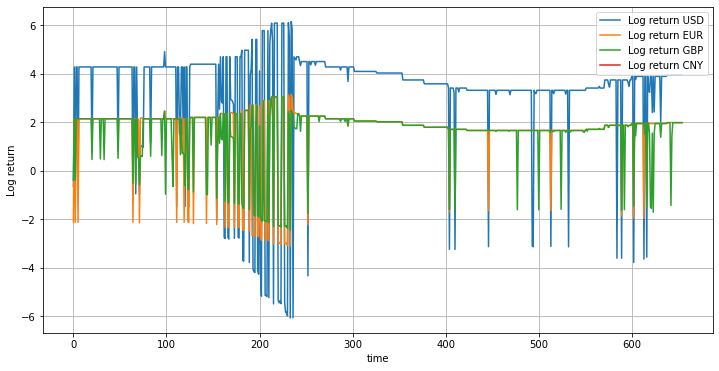

In [73]:
cum_ret = get_profit(0.016, 1)[1]
plt.figure(figsize=(12, 6))
display(plt.plot(2*np.array(cum_ret[0]), label = 'Log return USD'))
display(plt.plot(np.array(cum_ret[1]), label = 'Log return EUR'))
display(plt.plot(np.array(cum_ret[2]), label = 'Log return GBP'))
display(plt.plot((-1)*cum_ret[3], label = 'Log return CNY'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('Log return');
## ставку японской йены не берем, так как ее вес 0